# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [2]:
print(data.head())
data.info()
data.describe()

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


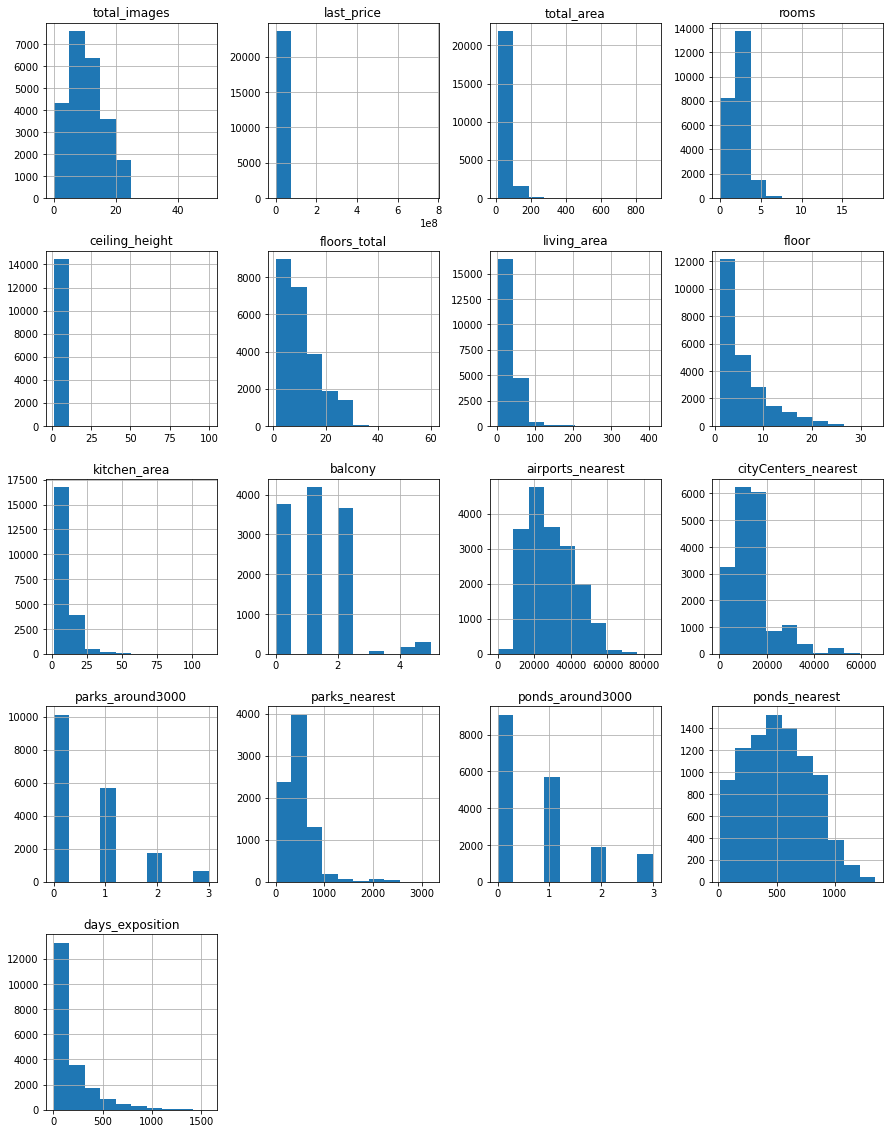

In [3]:
data.hist(figsize=(15, 20));

В данных замечены следующие проблемы:

-  Пропуски
-  Категориальные значения
-  Неверный формат времени
-  Неправильные названия столбцов
-  Выбросы и аномальные значения

### Предобработка данных

In [4]:
# заменим название столбца
data.rename(columns = {'cityCenters_nearest':'center_nearest'}, inplace=True)

-  balcony - параметр, который указал пользователь, соответственно, если стоит пропуск - скорее всего балконов нет, можно заменить на нулевое значение.
-  floors_total коррелируется со столбцом floor, заменим пропуски на медианные значения, сгруппировав данные.
-  ceiling_height потолки это довольно стандартизированная величина, поэтому можно безболезненно заменить их медианой
-  kitchen_area хорошо коррелируется со столбцом total_area, поэтому, сгруппировав данные, заменим пропуски на медианные значени по группам.
-  floors_total коррелируется со столбцом floor, заменим пропуски на медианные значения, сгруппировав данные.
-  Пропуски в населенных пунктах можно удалить. Мы не можем быть уверены, что эти квартиры принадлежат Санкт-Перербургу.

In [5]:
# пропуски
print (data.isna().sum())

# меняем пропуски на нулевое значение
data['balcony'] = data['balcony'].fillna(0)

# заполняем пропуски на медианное значение
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['floors_total'] = data['floors_total'].fillna(data.groupby('floor')['floors_total'].transform('median'))
data['living_area'] = data['living_area'].fillna(data.groupby(['total_area', 'rooms'])['living_area'].transform('median'))
data['kitchen_area'] = data['kitchen_area'].fillna(data.groupby('total_area')['kitchen_area'].transform('median'))

# удаляем пропуски в населенных пунктах
data.dropna(subset = ['locality_name'], inplace = True)

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
center_nearest           5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


-  first_day_exposition - необходимо перевести в формат Datatime
-  привести значения в столбце locality_name к единому стилю
-  округлить значения в столбце last_price до тысячи
-  total_area, last_price, living_area, kitchen_area, airports_nearest, center_nearest, parks_nearest, ponds_nearest, - нужно округлить и заменить на целочисленные значения.
-  floors_total, balcony, parks_around3000, ponds_around3000, days_exposition - заменить на целочисленные значения.

In [6]:
# меняем формат времени
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

# заменим букву ё на букву е
# приведем все к нижнему регистру
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.lower()

# переведем цену в тыс. рублей
data['last_price'] = round(data['last_price'] / 1000, 1)

In [7]:
# округляем значения
data = data.round({
    'total_area':0,
    'last_price':0,
    'living_area':0,
    'kitchen_area':0,
    'airports_nearest':0,
    'center_nearest':0,
    'parks_nearest':0,
    'ponds_nearest':0,
    'days_exposition':0 })

# меняем тип данных на целочисленный
data = data.astype({
    'living_area':'Int64',
    'kitchen_area':'Int64',
    'floors_total':'Int64',
    'balcony':'Int64',
    'airports_nearest':'Int64',
    'center_nearest':'Int64',
    'parks_around3000':'Int64',
    'parks_nearest':'Int64',
    'ponds_around3000':'Int64', 
    'ponds_nearest':'Int64',
    'days_exposition':'Int64' })

In [8]:
# Дубликатов в данных нет
data.duplicated().sum()

0

Уберем редкие и выбивающиеся значения

(0.0, 10.0)

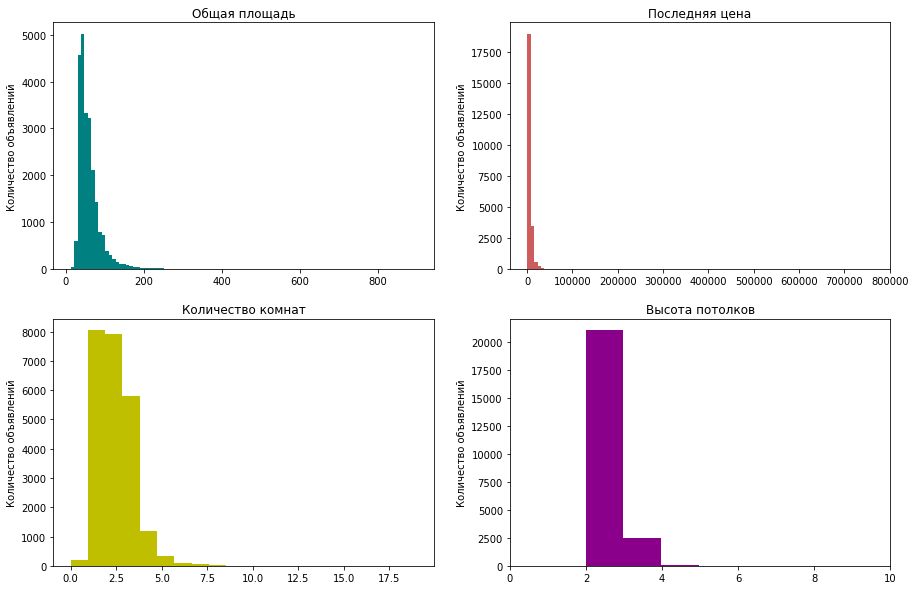

In [9]:
fig = plt.figure(figsize=(15, 10))
axes = fig.subplots(2, 2)

# изучим распределение общей площади в объявлениях
axes[0, 0].hist(data['total_area'], bins=100, color='teal')
axes[0, 0].set_title('Общая площадь')
axes[0, 0].set_ylabel('Количество объявлений')

# изучим распределение цены в объявлениях
axes[0, 1].hist(data['last_price'], bins=100, color='indianred')
axes[0, 1].set_title('Последняя цена')
axes[0, 1].set_ylabel('Количество объявлений')
 
# изучим распределение комнат в объявлениях
axes[1, 0].hist(data['rooms'], bins=20, color='y')
axes[1, 0].set_title('Количество комнат')
axes[1, 0].set_ylabel('Количество объявлений')
axes[1, 1].set_xlim(0, 10)

# изучим распределение высоты потолков в объявлениях
axes[1, 1].hist(data['ceiling_height'], bins=100, color='darkmagenta')
axes[1, 1].set_title('Высота потолков')
axes[1, 1].set_ylabel('Количество объявлений')
axes[1, 1].set_xlim(0, 10)

In [10]:
print ('Аномалии в параметре общей площади', data.query('total_area > 300')['locality_name'].count())
print ('Аномалии в параметре цены', data.query('last_price > 40000 or last_price < 500')['locality_name'].count())
print ('Аномалии в параметре комнат', data.query('rooms > 10 or rooms == 0')['locality_name'].count())
print ('Аномалии в параметре высоты потолков', data.query('ceiling_height > 5 or ceiling_height < 2')['rooms'].count())

Аномалии в параметре общей площади 61
Аномалии в параметре цены 196
Аномалии в параметре комнат 205
Аномалии в параметре высоты потолков 39


In [11]:
# отсекем слишком большую площадь
data = data.query('total_area < 150')

# отсекем цену более 40000 и менее 500
data = data.query('last_price < 40000 and last_price > 500')

# отсекем квартиры с количеством комнат более 10
data = data.query('rooms < 10')
# квартиры с 0 количеством комнат заменим на 1
data.loc[(data.rooms < 1), 'rooms'] = 1

# отсекаем высоту потолков больше 10 метров
data = data.query('ceiling_height < 5 and ceiling_height > 2')

Данные предобработаны:

-  Заголовки приведены к единому стилю
-  Обработано большинство пропусков
-  Заменены типы данных на численные
-  Дубликатов нет
-  Мы избавились от аномальных значений, распределения параметров нормальные

### Посчитайте и добавьте в таблицу новые столбцы

Необходимо посчитать и добавить в таблицу:

-  цену квадратного метра;
-  день недели, месяц и год публикации объявления;
-  этаж квартиры; варианты — первый, последний, другой;
-  соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [12]:
# добавим цену за квадратный метр
data['per_meter'] = (data['last_price'] / data['total_area']).round().astype('int')

In [13]:
# добавим день недели, месяц и год публикации объявления
data['weekday'] = pd.DatetimeIndex(data['first_day_exposition']).weekday
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year
data = data.drop('first_day_exposition', axis=1)

In [14]:
# добавим соотноение жилой и общей площади
data['living_to_total'] = (data['living_area'] / data['total_area']) * 100

# добавим соотношение кухни к общей площади
data['kitchen_to_total'] = (data['kitchen_area'] / data['total_area']) * 100

In [15]:
# добавим этаж квартиры
def floor_type (data):
    if data['floor'] == 1:
        return 'первый'
    if data['floor'] == data['floors_total']:
        return 'последний'
    else: 
        return 'другой'
data['floor_category'] = data.apply(floor_type, axis=1)

In [16]:
# добавим столбец с расстоянием до центра в километрах
data['kilo_to_center'] = (data['center_nearest'] // 1000).astype('Int64')

### Проведите исследовательский анализ данных

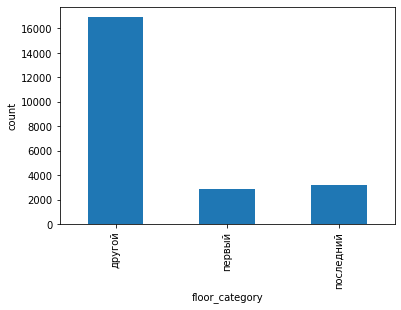

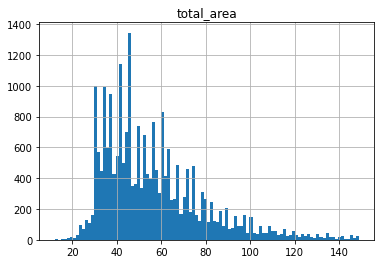

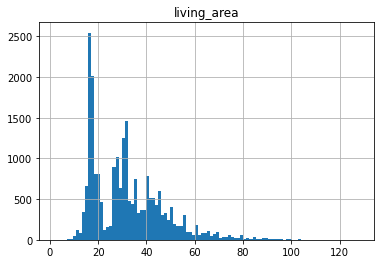

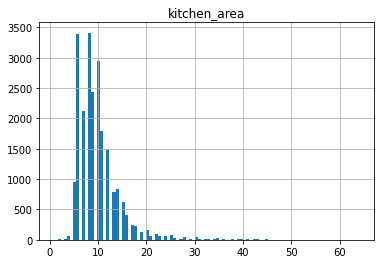

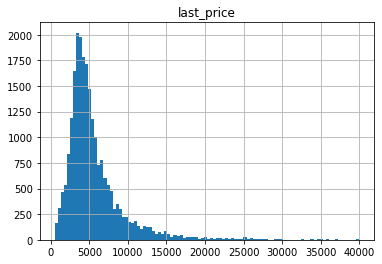

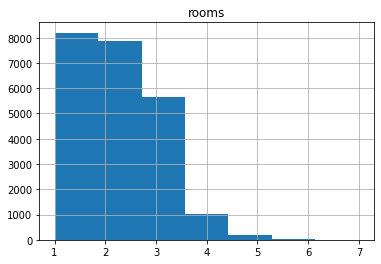

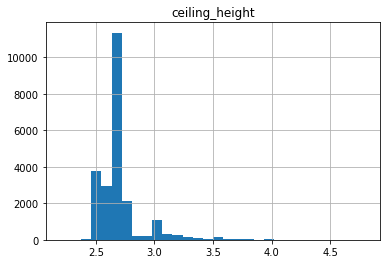

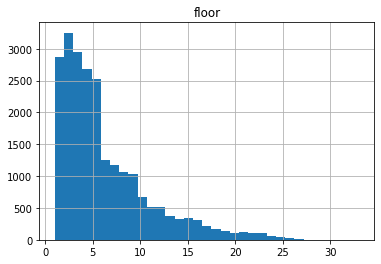

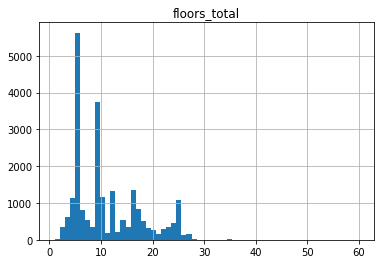

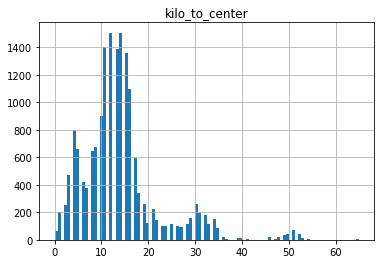

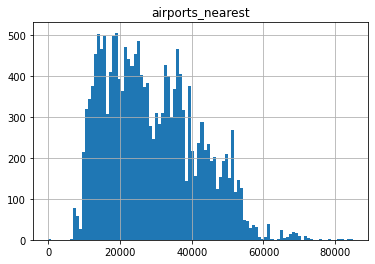

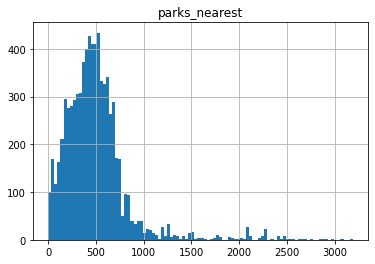

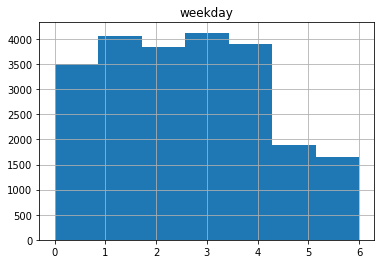

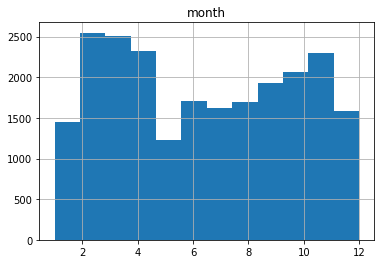

In [17]:
data.groupby(by='floor_category')['floor_category'].count().plot(kind='bar', ylabel = 'count');

data.hist('total_area', bins=100);

data.hist('living_area', bins=100);

data.hist('kitchen_area', bins=100);

data.hist('last_price', bins=100);

data.hist('rooms', bins=data['rooms'].max());

data.hist('ceiling_height', bins=30);

data.hist('floor', bins=data['floor'].max());

data.hist('floors_total', bins=data['floors_total'].max());

data.hist('kilo_to_center', bins=100);

data.hist('airports_nearest', bins=100);

data.hist('parks_nearest', bins=100);

data.hist('weekday', bins=7);

data.hist('month', bins=12);

Построили гистограммы для:

-  тип этажа квартиры («первый», «последний», «другой») в этом случае используем тип bar; Больше всего квартир на "другом" этаже и это логично. Первых и последних этажей одинакого мало.
-  общая площадь; Наблюдаем очень малое количество квартир с общей площадью более 100 кв.м.
-  жилая площадь; Наблюдаем два пика - на 18 кв.м. и на 30 кв.м. 
-  площадь кухни; Площадь кухни выглядит хорошо.
-  цена объекта; Цена объекта выглядит хорошо. Немного "шумный" график. Очень длинный "хвост" вправо - это похоже илитная недвижимость.
-  количество комнат; Больше всего один- и двух-комнатных квартир, но встречаются и редкие исключения.
-  высота потолков; от 2.5м, что логично.
-  этаж квартиры; Больше всего квартир с 1 по 5 этаж. Логино, питер не город небоскрёбов
-  общее количество этажей в доме; Видим явные пики: 5-этажная застройка, 9-этажная застройка, и небольшие пики более высоких новостроек.
-  расстояние до центра города в метрах; Здесь наблюдаем два пика, один маленький, 5км и другой побльшой от 10 км. до 15 км. Так же есть совсем небольшие всплески на 30 км. и 50 км.
-  расстояние до ближайшего аэропорта; Здесь видим довольно "шумный" график. Но это вполне нормально.
-  расстояние до ближайшего парка; Судя по графику больше всего квартир с парками на расстоянии до 750м.
-  день и месяц публикации объявления. Видим провал в публикации объявлений в субботу и воскресенье, что логично. Так же видим что с февраля по апрель наблюдалосась повышенная активность. Так же был плавный рост активности с июля по ноябрь. Провалы в декабре, январе и мае.

Text(0, 0.5, 'Количество объявлений')

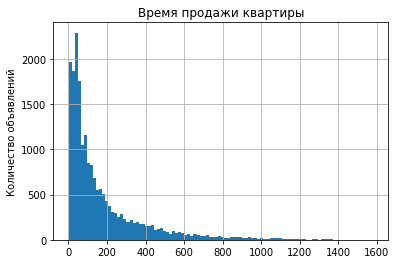

In [18]:
# изучим время продажи квартиры
data['days_exposition'].hist(bins=100)
plt.title('Время продажи квартиры')
plt.ylabel('Количество объявлений')

12.52123165367362

count    19951.000000
mean       177.931683
std        217.058190
min          1.000000
25%         44.000000
50%         94.000000
75%        226.000000
max       1580.000000
Name: days_exposition, dtype: float64

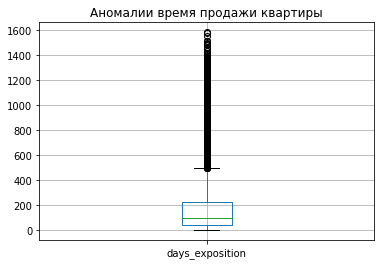

In [19]:
# проверим долю продаж дольше года и сделаем описание данных
display (data[data['days_exposition'] > 365]['days_exposition'].count() / data.shape[0] * 100)
display (data['days_exposition'].describe())

data.boxplot(column='days_exposition')
plt.title('Аномалии время продажи квартиры')
plt.show()

Text(0, 0.5, 'Количество объявлений')

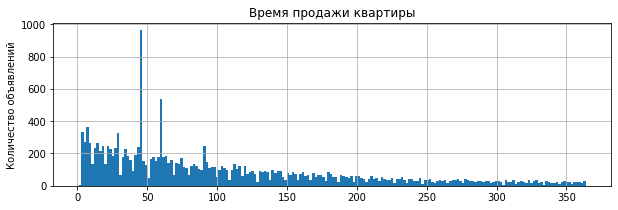

In [20]:
# уберем аномально долгие продажи больше года
data = data[data['days_exposition'] < 365]
data['days_exposition'].hist(bins=200, figsize=(10, 3))
plt.title('Время продажи квартиры')
plt.ylabel('Количество объявлений')

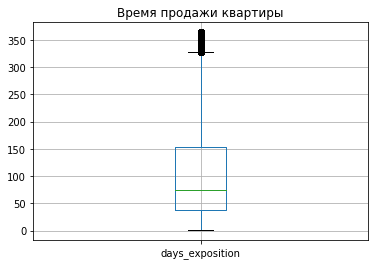

In [21]:
import matplotlib.pyplot as plt
data.boxplot(column='days_exposition')
plt.title('Время продажи квартиры')
plt.show()

-  До 50 дней - продажа прошла быстро
-  До 150 дней - среднее время продажи
-  До 350 дней - долгая продажа

3951


'Зависимость цены от площади: '

,total_area,last_price
total_area,1.000000,0.733656
last_price,0.733656,1.000000


'Зависимость цены от числа комнат'

,rooms,last_price
rooms,1.000000,0.445041
last_price,0.445041,1.000000


'Зависимость цены от удаленности от центра'

,center_nearest,per_meter
center_nearest,1.000000,-0.369417
per_meter,-0.369417,1.000000


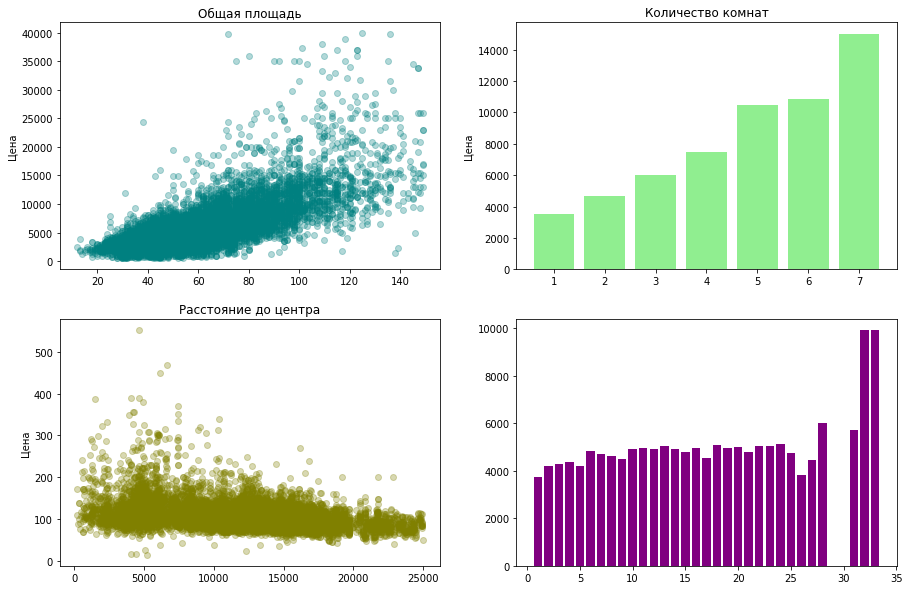

In [22]:
fig = plt.figure( figsize=(15, 10))
axes = fig.subplots(2, 2)

# ПЛОЩАДЬ
axes[0, 0].scatter(x=data['total_area'], y=data['last_price'],  alpha=0.3, color='teal')
axes[0, 0].set_title('Общая площадь')
axes[0, 0].set_ylabel('Цена')

# ЧИСЛО КОМНАТ
rooms_median = data.pivot_table(index='rooms', values='last_price', aggfunc='median')
axes[0, 1].bar(x=rooms_median.index, height=rooms_median['last_price'], color='lightgreen')
axes[0, 1].set_title('Количество комнат')
axes[0, 1].set_ylabel('Цена')

# УДАЛЕННОСТЬ ОТ ЦЕНТРА
# сначала очистим от аномальных значений
clean_center = data[data['center_nearest'] < 25000]

# добавим столбец с расстоянием до центра в километрах
print(data['center_nearest'].isna().sum())
axes[1, 0].scatter(x=clean_center['center_nearest'], y=clean_center['per_meter'], alpha=0.3, color='olive')
axes[1, 0].set_title('Расстояние до центра')
axes[1, 0].set_ylabel('Цена')

# ЭТАЖ
floor_median = data.pivot_table(index='floor', values='last_price', aggfunc='median')
axes[1, 1].bar(x=floor_median.index, height=floor_median['last_price'], color='purple')


display ('Зависимость цены от площади: ', data[['total_area', 'last_price']].corr())
display ('Зависимость цены от числа комнат', data[['rooms','last_price']].corr())
display ('Зависимость цены от удаленности от центра', clean_center[['center_nearest', 'per_meter']].corr())

Вывод

-  Цена квартиры напрямую коррелирует с общей площадью квартиры, значит параметр площади - важный фактор при оценивании квартиры
-  Цена также зависит от количества комнат, однако здесь мы анализируем отношение общей цены и число комнат. Цена за квадратный метр в однокомнатной квартире будет больше, чем в квартире с 2 и больше комнатами.
-  Цена зависит от удаленности от центра, однако не связь слабее, чем у цены и площади.
-  Квартиры на первом этаже чаще дешевле.

Изучим время продажи квартир. Для начала посмотрим на количество дней, за которое квартира была продана

In [23]:
# получение количества уникальных значений по дням для продажи квартиры, сортировка этих значений и вывод первых 10
data['days_exposition'].value_counts().sort_values(ascending=False).head(10)

45    873
60    538
7     231
30    204
90    180
4     174
3     158
5     148
14    143
9     138
Name: days_exposition, dtype: Int64

Наиболее часто продают квартиры за 45 и 60 дней. Построим гистрограмму. Ограничим её значением в 600 дней (чуть менее 2 полных лет)

<AxesSubplot:ylabel='Frequency'>

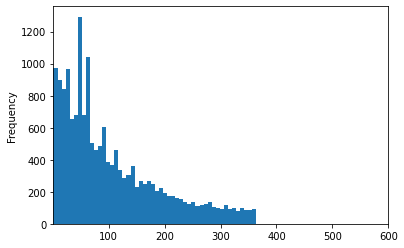

In [24]:
# строим гистограмму по количеству дней для продажи квартиры в таблице
data['days_exposition'].plot(kind='hist', bins=50, xlim=(1, 600))

In [25]:
#рассчитываем среднее арифметическое и медиану для количества дней для продажи квартиры
print("Среднее арифметическое количество дней для продажи квартир: {:.2f}".format(data['days_exposition'].mean()))
print("Медиана количества дней для продажи квартир:", data['days_exposition'].median())

Среднее арифметическое количество дней для продажи квартир: 104.06
Медиана количества дней для продажи квартир: 74.0


Среднее арифметическое и медиана существенно отличаются друг от друга. Это говорит нам о том, что в выборке есть много крупных значений, то есть тех, кто очень долго продавал квартиру. Как видно на гистограмме, действительно, процесс этот часто оказывается очень длинным. У нас наблюдается ожидаемый пик в первом столбце, где представлены объявления, чьи квартиры не были проданы. Без него видно, что наиболее часто квартиры продают примерно до 100 дней, что и показывает нам наша медиана.

Факторы оторые больше всего влияют на общую (полную) стоимость объекта

<AxesSubplot:xlabel='last_price', ylabel='kitchen_area'>

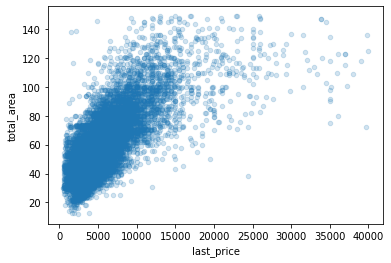

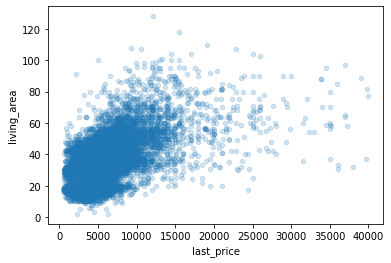

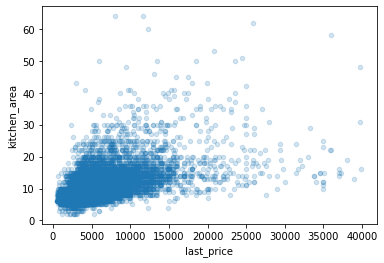

In [26]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.2)
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.2)
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.2)

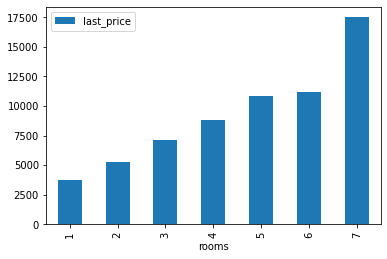

In [27]:
data.pivot_table(index='rooms',values='last_price').plot(y='last_price', kind='bar');

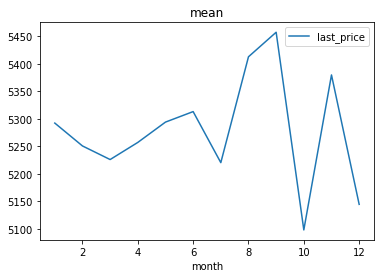

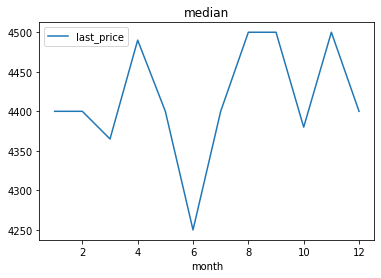

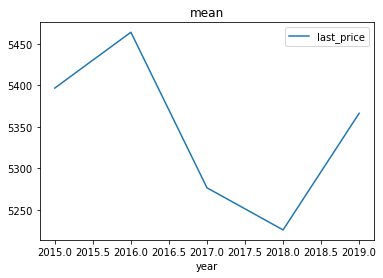

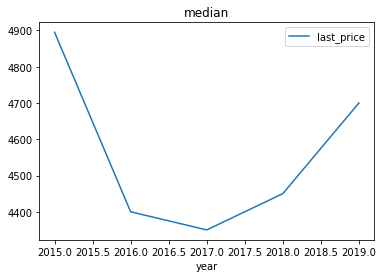

In [28]:
data.pivot_table(index='month',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='month',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

data.pivot_table(index='year',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='year',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

Цена зависит от:

-  общей площади;
-  жилой площади;
-  площади кухни;
-  количества комнат.

Цена практически на зависит от:

-  даты размещения.

In [29]:
# найдем населенные пункты с наибольшим числом объявлений
data_pivot = data.pivot_table(index='locality_name', values='per_meter',
                              aggfunc=['count', 'mean', 'min', 'max']
                             ).sort_values(('count', 'per_meter'),ascending=False).head(10)
data_pivot.sort_values(('mean', 'per_meter'))

,count,mean,min,max
,per_meter,per_meter,per_meter,per_meter
locality_name,,,,
выборг,177,57.254237,19,93
гатчина,220,68.227273,11,106
всеволожск,285,69.217544,31,642
колпино,274,74.529197,48,125
поселок шушары,363,78.305785,48,148
поселок мурино,491,86.040733,50,140
поселок парголово,262,89.041985,48,138
деревня кудрово,259,92.768340,54,143


Как найти задание 4.3

Среди населенных пунктов с большим количеством объявлений - Санкт-Петербург, Пушкин, Деревня Кудрово - пункты с самой дорогой ценой за квадратный метр и Выборг, Всеволожск, Гатчина - с самой дешевой.

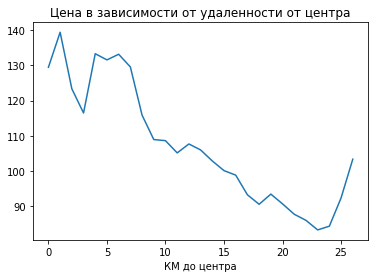

In [30]:
data['kilo_to_center'] = (data['center_nearest'] / 1000).astype('Int64')

# создадим новую таблицу с объявлениями в Питере
piter_flats = data[data['locality_name'] == 'санкт-петербург']
piter_flats = data[data['kilo_to_center'] < 27]

# построим график зависимости цены от удаленности от центра
piter_flats.groupby('kilo_to_center')['per_meter'].mean().plot()
plt.title('Цена в зависимости от удаленности от центра')
plt.xlabel('КМ до центра')
plt.show()

Определим границу, где график сильно меняется, — это и будет центральная зона. Цена квартир заметно снижается на 3 километре, подъем после 3 можно объяснить тем, что тут появляются особые квартиры с большей площадью, например, или с хорошим видом. Будем считать до 3 км - центр города.

### Общий вывод

Чаще всего в объявлениях встречаются квартиры от 30 до 60 кв/м. Средняя цена находится в диапазоне от 2 500 000 до 5 000 000 млн руб. Квартиры чаще всего однокомнатные или двухкомнатные. Высота потолков в квартирах в среднем 2.7 метра. Среднее время продажи квартиры от 50 до 150 дней.

Последняя цена квартиры напрямую зависит от количества комнат. Цена квартиры коррелирует с общей площадью квартиры, наиболее выгодная цена за квадратный метр у квартир с 3-5 комнатами. Чем дальше от центра находится квартира, тем меньше ее стоимость.

Центральная часть Санкт-Петербурга. Квартиры, находящиеся на первых этажах обычно стоят дешевле. До 1 км до центра и в трех километрах от центра квартиры чуть дешевле всех остальных, расположенных в центральной части Питера. С каждым годом стоимость квадратного метра в центре Питера растет.

Центр в сравнении с окраинами. Площадь квартир в центре Санкт-Петербурга в среднем больше средней площади по всему городу. Средняя цена объявлений во всем городе от 2 до 5.5 млн, тогда как в центре от 5 до 8 млн. Большинство объявлений в центре Питера - двухкомнатные и трехкомнатные квартиры, а по всему городу чаще всего выставляют однокомнатные. Высота потолков в центральной части Питера (3м) в среднем больше высоты потолков в остальном городе (2.5м).